In [37]:
from localtileserver import get_leaflet_tile_layer, TileClient
from ipyleaflet import Map, WidgetControl, DrawControl, LayersControl
import ipywidgets

import rioxarray as rxr
import xarray as xr
import numpy as np
from p_tqdm import p_map
import matplotlib.pyplot as plt
from time import time
import os

In [38]:
files = ["data/20230708_ms_koc_transparent_mosaic_blue_single.tif",
         "data/20230708_ms_koc_transparent_mosaic_green_single.tif",
         "data/20230708_ms_koc_transparent_mosaic_nir_single.tif",
         "data/20230708_ms_koc_transparent_mosaic_red edge_single.tif",
         "data/20230708_ms_koc_transparent_mosaic_red_single.tif"]
def load_raster(file):
    return rxr.open_rasterio(file).astype('float32').rio.reproject("EPSG:4326")
rasters = p_map(load_raster, files)

  0%|          | 0/5 [00:00<?, ?it/s]

In [39]:
#get resolutions
resolutions = [abs(r.rio.resolution()[0]) for r in rasters]
#get indice of lowest resolution
lowest_res = resolutions.index(min(resolutions))
#reproject match to raster of lowest resolution
rasters = [r.rio.reproject_match(rasters[lowest_res]) for r in rasters]
#combine bands
rasters = xr.concat(rasters, dim='band')

/usr/local/lib/python3.11/dist-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rioxarray/raster_writer.py:130: UserWarning: The

In [40]:
#points are [[x,y],[x,y]...]
def probe_rasters(points):
    points = np.array(points)
    flag_1d = False
    #if points are not 2D, make them 2D
    if len(points.shape) == 1:
        flag_1d = True
        points = points.reshape(1,-1)
    #get pixel values
    values = rasters.sel(x=points[:,0], y=points[:,1], method='nearest').values
    #get diagonal values
    values = np.diagonal(values, axis1=1, axis2=2)
    if flag_1d:
        values = values.squeeze()
    return values



In [59]:
basemap_client = TileClient('data/20230708_ms_koc_transparent_mosaic_blue_single.tif')
m = Map(center=basemap_client.center(), zoom=basemap_client.default_zoom, scroll_wheel_zoom=True)
basemap_layer = get_leaflet_tile_layer(basemap_client, name='Raster')
m.add_layer(basemap_layer)
m.add_control(LayersControl(position='bottomright'))

#custom toolbar
toolbar = ipywidgets.VBox()
pos_button = ipywidgets.ToggleButton(description='Positive')
pos_button.set_trait('value', True)
state = True
neg_button = ipywidgets.ToggleButton(description='Negative')
clear_button = ipywidgets.Button(description='Clear')
def pos_button_event(b):
    global state
    if b["new"]==True:
        #untoggle other buttons
        neg_button.set_trait('value', False)
        state = True
def neg_button_event(b):
    global state
    if b["new"]==True:
        #untoggle other buttons
        pos_button.set_trait('value', False)
        state = False
def clear_button_event(b):
    global pos_points, neg_points, pos_values, neg_values
    pos_points = []
    neg_points = []
    pos_values = []
    neg_values = []
    draw_control.clear()
#add events to buttons
pos_button.observe(pos_button_event, names=['value'])
neg_button.observe(neg_button_event, names=['value'])
clear_button.on_click(clear_button_event)
#add buttons to widget
toolbar.children = [pos_button, neg_button, clear_button]
m.add_control(WidgetControl(widget=toolbar, position='topright'))

draw_control = DrawControl(polyline={}, polygon={}, circle={}, rectangle={}, circlemarker={}, marker={"repeatMode": True}, edit=False, remove=False)
pos_points = []
neg_points = []
pos_values = []
neg_values = []
def draw_event(target, action, geo_json):
    if state == True:
        draw_control.clear()
        point = geo_json['geometry']['coordinates']
        pos_points.append(point)
        pos_values.append(probe_rasters(point))
    elif state == False:
        draw_control.clear()
        point = geo_json['geometry']['coordinates']
        neg_points.append(point)
        neg_values.append(probe_rasters(point))

draw_control.on_draw(draw_event)
m.add_control(draw_control)
m

Map(center=[50.86802385962113, 18.955818508047887], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [65]:


pos_means = np.array(pos_values).mean(axis=0)
pos_stds = np.array(pos_values).std(axis=0)
n = 3
#initialize single channel rxr raster of ones with the same shape as rasters
mask = xr.ones_like(rasters)
#set mask to 0 where values are within n standard deviations from the mean
mask = mask.where((rasters > pos_means[:, None, None] - n*pos_stds[:, None, None]) & (rasters < pos_means[:, None, None] + n*pos_stds[:, None, None]), 0)
#multiply by axis=0 to get a single channel raster
mask = mask.prod(axis=0)
#generate tmp file name based on timestamp

#if mask_path exists
if 'mask_path' in globals():
    for layer in m.layers:
        if layer.name == 'Mask':
            m.remove_layer(layer)
            del mask_layer
            del mask_client
            #delete file
            os.remove(mask_path)
#save mask to temporary file
mask_path = f'data/mask_{int(time()*1000)}.tif'
mask.rio.to_raster(mask_path)
mask_client = TileClient(mask_path)
mask_layer = get_leaflet_tile_layer(mask_client, name='Mask')

m.add_layer(mask_layer)

In [48]:
from localtileserver.tiler.utilities import get_cache_dir

In [50]:
get_cache_dir()

PosixPath('/tmp/localtileserver')

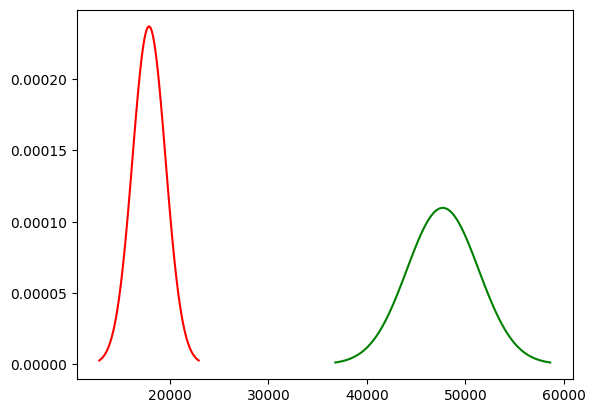

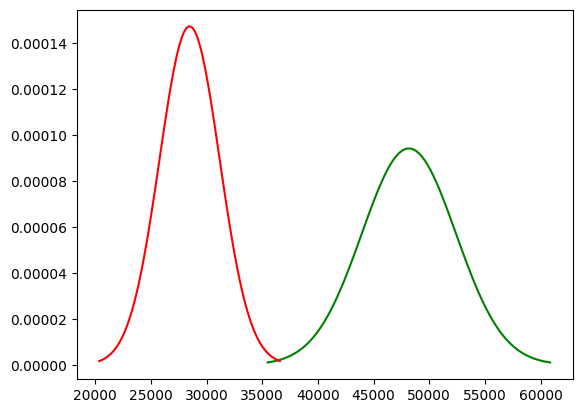

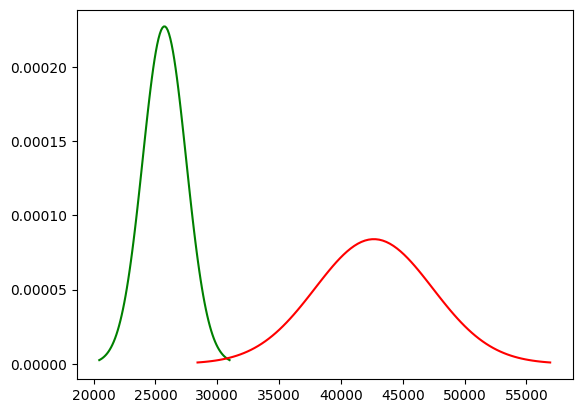

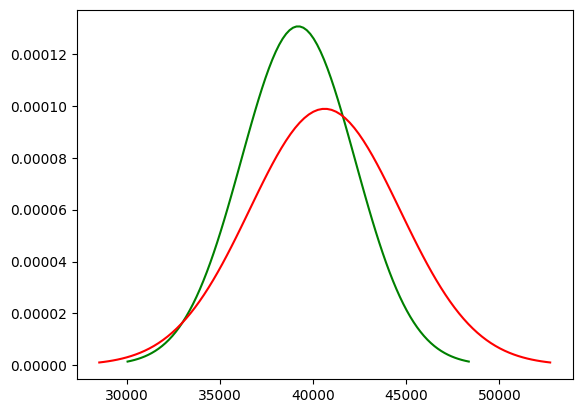

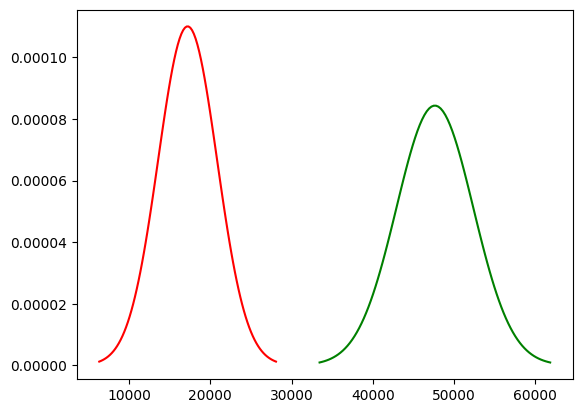

In [31]:
    pos_means = np.array(pos_values).mean(axis=0)
    pos_stds = np.array(pos_values).std(axis=0)
    neg_means = np.array(neg_values).mean(axis=0)
    neg_stds = np.array(neg_values).std(axis=0)
for pos_mean, pos_std, neg_mean, neg_std in zip(pos_means, pos_stds, neg_means, neg_stds):
    plt.figure()
    ax = plt.gca()
    #plot gaussian
    x_pos = np.linspace(pos_mean-3*pos_std, pos_mean+3*pos_std, 100)
    y_pos = np.exp(-(x_pos-pos_mean)**2/(2*pos_std**2))/(np.sqrt(2*np.pi)*pos_std)
    ax.plot(x_pos, y_pos, color='green')
    plt.plot()
    x_neg = np.linspace(neg_mean-3*neg_std, neg_mean+3*neg_std, 100)
    y_neg = np.exp(-(x_neg-neg_mean)**2/(2*neg_std**2))/(np.sqrt(2*np.pi)*neg_std)
    ax.plot(x_neg, y_neg, color='red')
    plt.plot()